# Pruebas de Jeffreys-Guyer-Krumhansl

## Modelo de JGK
## $$\dfrac{\partial T}{\partial t} + \tau_q \dfrac{\partial^2 T}{\partial t^2} = \alpha \left[\dfrac{\partial^2 T}{\partial x^2} + \beta \dfrac{\partial}{\partial t} \left(\dfrac{\partial^2 T}{\partial x^2}\right)\right]$$

## $$q + \tau_q \dfrac{\partial q}{\partial t} = - \left[\dfrac{\partial T}{\partial x} + \beta \dfrac{\partial}{\partial t} \left(\dfrac{\partial T}{\partial x}\right)\right]$$

## $$q(t + \tau_q) \simeq q + \tau_q \dfrac{\partial q}{\partial t}; \quad \dfrac{\partial T}{\partial t}(t + \tau_q) \simeq \dfrac{\partial T}{\partial t} + \tau_q \dfrac{\partial^2 T}{\partial t^2}; \quad \dfrac{\partial T}{\partial x}(t + \beta) \simeq \dfrac{\partial T}{\partial x} + \beta \dfrac{\partial}{\partial t} \left(\dfrac{\partial T}{\partial x}\right)$$

## $$\dfrac{\partial^2 T}{\partial x^2} (t + \beta) \simeq \dfrac{\partial^2 T}{\partial x^2} + \beta \dfrac{\partial}{\partial t} \left(\dfrac{\partial^2 T}{\partial x^2}\right) $$

## Con las variables causales
### $A = \dfrac{\partial T}{\partial t}, \quad B = \dfrac{\partial^2 T}{\partial x^2}$
### $C = q, \quad D  = \dfrac{\partial T}{\partial x}, \quad E = T$

La ecuación de transporte esta dada en su forma adimensional por medio de las siguientes variables adimensionales y parámetros:
* $T$ es la temperatura
* $t$ es el tiempo
* $D$ es la difusividad térmica
* $x$ es la dirección espacial x
* $q$ es el flujo de calor
* El parámetro $\alpha$ es el número de Fourier $\alpha = D t_c L^{-2}$
* Con $t_c$ es el tiempo característico, $D$ es la difusividad térmica del material y $L$ es la longitud del material
* El parámetro $\beta$ es  $\beta = l^2 D^{-1} t_c^{-1}$
* Con $l$ la longitud libre media de los fonones
* El parámetro $\tau$ es el tiempo efectivo $\tau = \Delta t_q t_c^{-1}$
* Con $\Delta t_q$ es el tiempo de retardo del flujo de calor

Este problema en particular se va a resolver para dos casos a las condiciones de frontera:

Determinista
* $\quad T(x = 1, t) = 1 \quad$ $T(x = 0, t) = \mu_\epsilon$

Estocástico
* $\quad T(x = 1, t) = 1 \quad$ $T(x = 0, t) = \epsilon(t)$ 

Con $\epsilon(t)$ ruido blanco Gaussiano y $\mu_\epsilon$ su promedio

Y la condición inicial para ambos casos
* $T(x, t = 0) = 1$

### Importación de bibliotecas y módulos

In [1]:
from IPython import display
import ipywidgets
import numpy as np               
import matplotlib.pyplot as plt  
import seaborn as sns
from numba import jit
import modulo_jeffreys as mjgk

### Opciones de graficación
Estética de las gráficas

In [2]:
sns.set_style("darkgrid")
sns.set_context("paper", font_scale = 1.6)

## Función de simulación
Dependiendo de la frontera, se tiene la simulacion determinista o estocastica

In [3]:
@jit(nopython = True)
def simulacion(frontera):
    global nx, nt, alfa, tau, dx, dt, xpi, perfil_analitico, variacion_inicial
    # Condicion inicial
    temperatura = perfil_analitico + variacion_inicial
    flujocalor = - mjgk.ddx(temperatura, dx, full = True)
    u = np.zeros(nx)
    # Inicializacion de las series de tiempo
    serie_a = np.empty(nt)
    serie_b = np.empty(nt)
    serie_c = np.empty(nt)
    serie_d = np.empty(nt)
    serie_e = np.empty(nt)
    # Proceso de la simulacion
    for n in range(nt):
        # Frontera. Al instante n se le asigna el valor correspondiente a la frontera
        temperatura[0] = frontera[n]
        # Calculo de u (derivada de la temperatura respecto al tiempo)
        u = mjgk.rungekutta_u(u, temperatura, alfa, tau_q, beta, dx, dt)
        # Calculo de la temperatura
        temperatura = mjgk.calc_T(temperatura, u, dt)
        # Calculo del flujo de calor
        flujocalor = mjgk.rungekutta_q(flujocalor, temperatura, u, tau_q, beta, dx, dt)
        # Calculo del gradiente y laplaciano de la Temperatura, y laplaciano del flujo de calor
        lap_temperatura = mjgk.d2dx2(temperatura, dx, full = True)
        grad_temperatura = mjgk.ddx(temperatura, dx, full = True)
    return temperatura

## Archivo del ensamble de realizaciones de la frontera

In [4]:
ensamble_fronteras = np.loadtxt("datos/base/fronteras.csv", delimiter = ",")
ensamble_fronteras.shape

(128, 100001)

## Archivo de la condición inicial de la Temperatura

In [5]:
condicion_inicial = np.loadtxt("datos/base/variacion_inicial.csv")
condicion_inicial.shape

(128, 251)

## Dominio espacial

La solución numérica del problema se presenta solo en una dimensión espacial

In [6]:
x = np.loadtxt("datos/base/espacio_simulacion.csv")  # Vector del dominio espacial
nx = x.size                                          # Numero de puntos en el espacio
Lx = x[-1]                                           # Longitud del dominio espacial
dx = x[1] - x[0]                                     # Tamaño de paso en el espacio
dx

0.004

## Dominio temporal

El tiempo que se pretende dar solución al sistema de ecuaciones

In [7]:
t = np.loadtxt("datos/base/tiempo_simulacion.csv")  # Vector del dominio temporal, contiene nt+1 puntos incluyendo el 0
nt = ensamble_fronteras.shape[1]                    # Numero de pasos en el tiempo
Lt = t[-1]                                          # Longitud del dominio temporal
dt = t[1] - t[0]                                    # Tamaño de paso en el tiempo, 
dt

1e-05

## Fronteras

In [8]:
frontera_est = ensamble_fronteras[0]
frontera_det = np.mean(frontera_est) * np.ones(nt)

## Variación inicial

In [9]:
variacion_inicial = condicion_inicial[0]

## Solución analítica del estado estacionario
$ T(x) = 1 + a(1 - x)$

In [10]:
mu_frontera = np.mean(frontera_est) - 1.0
perfil_analitico = 1.0 + mu_frontera * (1.0 - x) 

## Parámetros de la simulación

Para los arreglos

In [11]:
xpi = int(nx / 5)                 # Punto de interes donde se capturan las series de tiempo
nr = ensamble_fronteras.shape[0]  # Numero de realizaciones del ensamble
x[xpi]

0.2

Valores termodinámicos

In [12]:
difusividad = 1.0                         # Valor de referencia de la difusividad
t_c = (Lx * Lx) / difusividad             # Tiempo caracteriztico
num_alfa = difusividad * t_c / (Lx * Lx)  # Valor del parametro alfa
t_c

1.0

Tiempo efectivo de retardo del flujo de calor

In [13]:
dtq = 15.0 * dt
tau_q = dtq / t_c
tau_q / dt

15.0

Parametro $\beta$

In [14]:
lfonon = np.sqrt(5.0 * dt)
lfonon

0.007071067811865475

In [15]:
beta = (lfonon * lfonon) / (difusividad * t_c)
beta / dt

5.0

Número de Fourier

In [16]:
alfa = num_alfa * np.ones(nx)  # Vector/arreglo alfa
alfa[0], alfa[-1] = 0, 0           # Extremos del vector/arreglo alfa

## Proceso principal

In [17]:
# Fronteras
frontera_est = ensamble_fronteras[0]
frontera_det = np.mean(frontera_est) * np.ones(nt)
# Simulaciones
perfil_est = simulacion(frontera_est)
perfil_det = simulacion(frontera_det)
# Progreso del trabajo
print("Terminado")

Terminado


## Gráficas de muestra

### Perfil de temperatura (calibración)

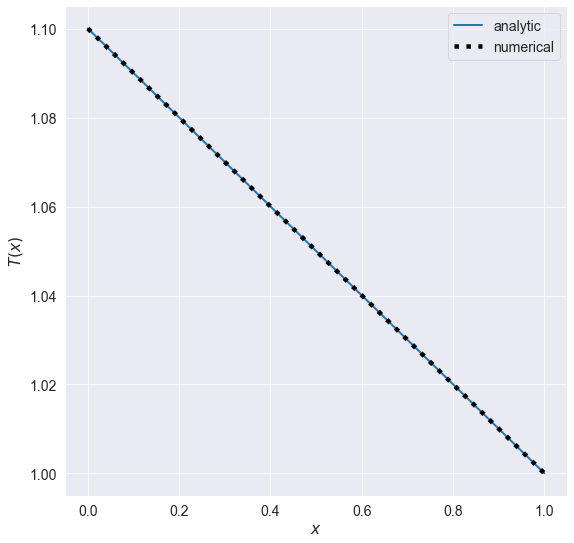

In [18]:
plt.figure(figsize = (9, 9))
plt.ylabel("$T(x)$")
plt.xlabel("$x$")
plt.plot(x, perfil_analitico, lw = 2.0, label = "analytic")
plt.plot(x, perfil_det, c = "black", ls = "dotted", lw = 4.5, label = "numerical")
plt.legend(loc = "best")
plt.savefig("graficas/muestra/guyer/guyer_perfil_temperatura.pdf", bbox_inches = "tight")
plt.show()